**Updated on: August 10, 2024**

# Introduction

**Project Overview:**

---

In this deep learning project, we developed a robust system to classify brain MRI scans into four categories: glioma tumor, meningioma tumor, pituitary tumor, or no tumor. Addressing the challenge of class imbalance, we employed the undersampling technique. Additionally, we enhanced our dataset through data augmentation techniques, including rotation, width shifting, height shifting, shearing, zooming, and horizontal flipping.



**Diverse Methodologies Applied: Exploring Three Distinct Approaches**

---
We adopted three distinct approaches for image classification and compared their performance on our dataset.

**First Approach:**

*Multi-Layer Convolutional Neural Network (CNN):* Our initial model utilized a multi-layer CNN architecture. The layers included convolutional, pooling, and fully connected layers, each contributing to the model's ability to detect and learn intricate patterns and features in the MRI images. We employed regularization through Dropout to handle overfitting. This structure allowed the model to progressively capture low-level features like edges and textures and then combine these into high-level features representing different tumor types.

***Updated:*** We applied a Class Activation Map (CAM) to one of the training images to understand how the model makes predictions. This visualization technique highlights the areas in the image that are most influential in the model's decision-making process. By overlaying the CAM on the original image, we can better interpret which regions of the image contribute to the model’s classification.

**Transfer Learning:**

We employed transfer learning, a technique where a pre-trained model is used as the starting point for a new task. This method leverages the knowledge gained from large datasets to enhance the learning process on smaller, task-specific datasets.

InceptionV3, originally developed by Google for the ImageNet competition, is a deep convolutional neural network that features inception modules. Inception modules work by employing multiple convolution filters of different sizes simultaneously to capture features at multiple scales within the same layer. These modules capture multi-scale features (low level to high level) through parallel convolutional operations of different sizes, making the model highly effective at recognizing complex patterns.

* *Second Model: Feature Extraction with InceptionV3:* We used the pre-trained weights from InceptionV3 to extract high-level features from the MRI images. This approach leverages the general image recognition capabilities of InceptionV3 to improve classification accuracy without training a model from scratch.

* *Third Model: Fine-Tuning InceptionV3:* In this model, we fine-tuned InceptionV3 by adjusting and retraining its deeper layers on our specific dataset. This allowed the model to adapt more closely to the nuances of our MRI images, enhancing its performance in distinguishing between different types of tumors and no tumor.


**References:**
*   Chollet, F. (2021). Deep Learning with Python. Manning Publications
*   Long, L., & Zeng, X. (2022). Beginning Deep Learning with TensorFlow: Work with Keras, MNIST Data Sets, and Advanced Neural Networks. Publisher.

**Authors:**
*   Raza Mehar (D03000023)
*   Syed Najam Mehdi (D03000017)
*   Pujan Thapa (D03000056)

# Utilities
---
This section sets up the environment for integrating Kaggle datasets and organizing image data for machine learning tasks. It defines a function, make_subset. This function organizes images from the original dataset into new training, validation, and test directories, ensuring an equal distribution of images from each class.

In [1]:
# Keras-vis to visualize Class Activation Maps.
!pip install keras-vis
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.6 MB/s eta 0:00:00


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img):
  img = img_to_array(img)
  img_array = np.expand_dims(img, axis=0)
  img_array = preprocess_input(img_array)

  return img_array

In [3]:
# Define a function that returns the count of images of each category from the specified directory.

import os

def get_image_count(base_dir_name, dir_name, sub_dir_name):
  dir_path = os.path.join(base_dir_name, dir_name)
  return len(os.listdir(os.path.join(dir_path, sub_dir_name)))

In [4]:
# Define a function that extracts images from the existing training and test folders.
# It distributes an equal number of images from each class into newly created training, validation, and test directories.

import shutil

# Define paths for the class directoriess
def make_subset(original_dir, subset_name, start_index, end_index):

  os.makedirs('/content/new', exist_ok=True)
  new_dir = '/content/new'

  for category in ('glioma', 'meningioma', 'pituitary', 'notumor'):
    dir_path = os.path.join(new_dir, subset_name, category)
    os.makedirs(dir_path, exist_ok=True)

    files_in_category = os.listdir(os.path.join(original_dir, category))
    files_to_copy = files_in_category[start_index:end_index]

    for file_name in files_to_copy:
      src_path = os.path.join(original_dir, category, file_name)
      dst_path = os.path.join(dir_path, file_name)
      shutil.copyfile(src=src_path, dst=dst_path)

In [5]:
# Define a function that display dimensions of random images.

def print_image_dimensions(dir, label, num):

    path = os.listdir(dir)
    if num > 1000:
      num = 1000

    random_indices = random.sample(range(1000), num)

    print(f"Dimensions of {num} random images in {label} directory are:")

    for i, idx in enumerate(random_indices):
      img_path = dir + path[idx]
      img = mpimg.imread(img_path)

      # If Grayscale image.
      if len(img.shape) == 2:
          height, width = img.shape
      # If Color image.
      elif len(img.shape) == 3:
          height, width, _ = img.shape
      else:
        print("Unsupported image format")

      print(f"\tImage Index: {idx}   \tImage dimensions: {width} x {height}")

In [6]:
# Define a function that returns the list of dimensions of all the images.

def get_image_dimensions(dir, label):

  path = os.listdir(dir)
  width_list = []
  height_list = []

  for idx in range(1000):
    img_path = dir + path[idx]
    img = mpimg.imread(img_path)

    # If Grayscale image.
    if len(img.shape) == 2:
        height, width = img.shape
    # If Color image.
    elif len(img.shape) == 3:
        height, width, _ = img.shape
    else:
      print("Unsupported image format")

    width_list.append(width)
    height_list.append(height)

  return width_list, height_list, label

In [88]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap_2(img_array, base_model, last_conv_layer_name, pred_index=None):
    # Ensure img_array has batch dimension
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Convert img_array to tensor
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = tf.keras.models.Model(
        [base_model.inputs], [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the convolutional layer output and apply the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)  # Weighted average
    heatmap = tf.maximum(heatmap, 0)  # ReLU activation
    heatmap /= tf.math.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()


In [114]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Data Downloading and Extraction

---
This section handles the downloading and extraction of the Brain Tumor MRI dataset. It utilizes the Kaggle API to download the dataset directly from Kaggle, then unzips the downloaded file into a specified directory for further use. The dataset URL and license information are provided for reference.


In [9]:
# Download the Brain Tumor MRI dataset using the Kaggle APIs
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 89% 132M/149M [00:00<00:00, 173MB/s]
100% 149M/149M [00:00<00:00, 160MB/s]


In [10]:
# Unzip the downloaded dataset
!unzip brain-tumor-mri-dataset.zip -d /content/original

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/original/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/original/Training/glioma/Tr-gl_0

# Data Overview

---
This section provides an overview of the dataset by counting and displaying the number of images in each category within the training and test directories. The function get_image_count is defined to calculate the number of images in specified sub-directories, and it is used to print the counts for 'glioma', 'meningioma', 'pituitary', and 'no tumor' images in both the training and test datasets.


In [11]:
# Print the number of images in the training, validation and test sub-directories.

print("Training directory:")
print("\tGlioma images:", get_image_count('original', 'Training', 'glioma'))
print("\tMeningioma images:", get_image_count('original', 'Training', 'meningioma'))
print("\tPituitary images:", get_image_count('original', 'Training', 'pituitary'))
print("\tNo tumor images:", get_image_count('original', 'Training', 'notumor'))

print("\nTest directory:")
print("\tGlioma images:", get_image_count('original', 'Testing', 'glioma'))
print("\tMeningioma images:", get_image_count('original', 'Testing', 'meningioma'))
print("\tPituitar:", get_image_count('original', 'Testing', 'pituitary'))
print("\tNo tumor images:", get_image_count('original', 'Testing', 'notumor'))

Training directory:
	Glioma images: 1321
	Meningioma images: 1339
	Pituitary images: 1457
	No tumor images: 1595

Test directory:
	Glioma images: 300
	Meningioma images: 306
	Pituitar: 300
	No tumor images: 405


# Handle Class Imabalance through Undersampling

---
In this section, class imbalance in the dataset is addressed through undersampling. The function make_subset is utilized to create new subsets of the training, validation, and test datasets with a balanced distribution of images from each class.

Following the undersampling process, the number of images in each category within the training, validation, and test directories is printed to verify the balanced distribution. The printed counts confirm the successful undersampling, with an equal number of images from each class in both the training and validation sets.

In [12]:
make_subset('/content/original/Training', 'train', 0, 1000)
make_subset('/content/original/Training', 'test', 1000, 1321)
make_subset('/content/original/Testing', 'val', 0, 300)

In [13]:
# Print the number of images in the training, validation and test sub-directories.
print("Training directory:")
print("\tGlioma images:", get_image_count('new', 'train', 'glioma'))
print("\tMeningioma images:", get_image_count('new', 'train', 'meningioma'))
print("\tPituitary images:", get_image_count('new', 'train', 'pituitary'))
print("\tNo tumor images:", get_image_count('new', 'train', 'notumor'))

print("\nValidation directory:")
print("\tGlioma images:", get_image_count('new', 'val', 'glioma'))
print("\tMeningioma images:", get_image_count('new', 'val', 'meningioma'))
print("\tPituitar:", get_image_count('new', 'val', 'pituitary'))
print("\tNo tumor images:", get_image_count('new', 'val', 'notumor'))

print("\nTest directory:")
print("\tGlioma images:", get_image_count('new', 'test', 'glioma'))
print("\tMeningioma images:", get_image_count('new', 'test', 'meningioma'))
print("\tPituitar:", get_image_count('new', 'test', 'pituitary'))
print("\tNo tumor images:", get_image_count('new', 'test', 'notumor'))

Training directory:
	Glioma images: 1000
	Meningioma images: 1000
	Pituitary images: 1000
	No tumor images: 1000

Validation directory:
	Glioma images: 300
	Meningioma images: 300
	Pituitar: 300
	No tumor images: 300

Test directory:
	Glioma images: 321
	Meningioma images: 321
	Pituitar: 321
	No tumor images: 321


# Data Visualization

---
This section focuses on visualizing random images from different classes within the training dataset and provides insights into the dimensions of these images.


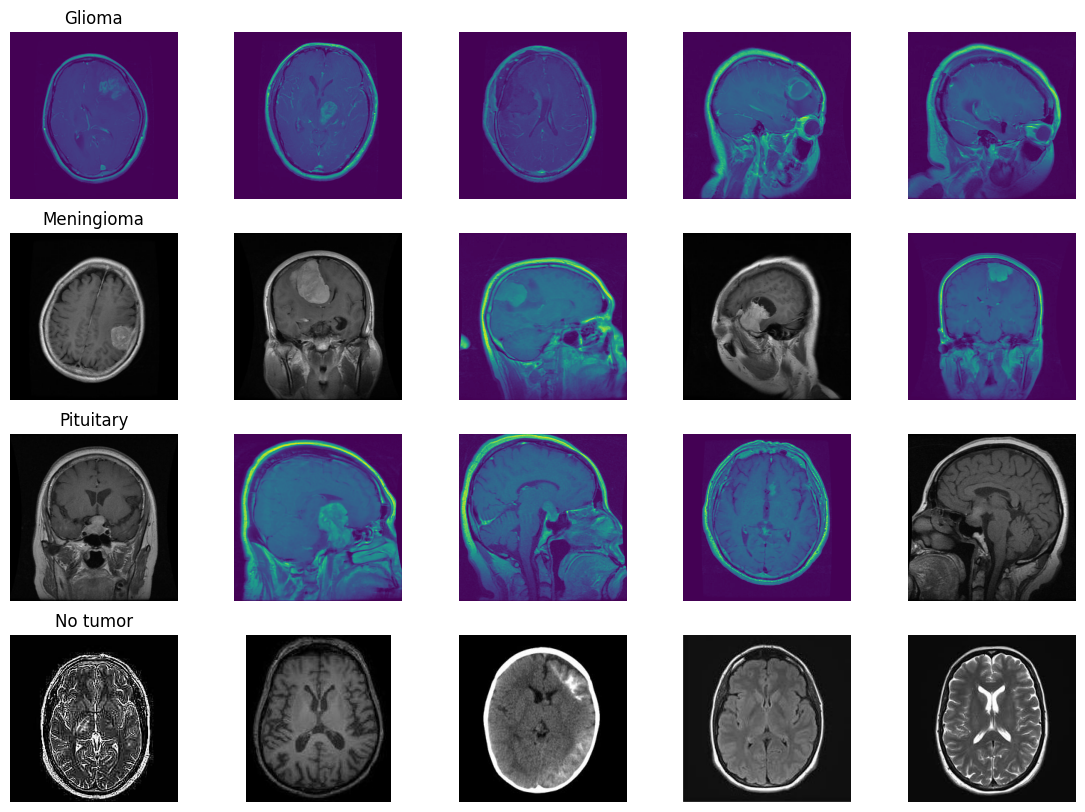

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Display random images of glioma, meningioma , pituitary, and no tumor from the training dataset.

num_of_images_to_show = 5

dir_path_glioma = 'new/train/glioma/'
dir_path_meningioma = 'new/train/meningioma/'
dir_path_pituitary = 'new/train/pituitary/'
dir_path_notumor = 'new/train/notumor/'

random_indices = random.sample(range(1000), num_of_images_to_show)

fig, axes = plt.subplots(4, num_of_images_to_show, figsize=(14,10))

axes[0, 0].set_title('Glioma')
axes[1, 0].set_title('Meningioma')
axes[2, 0].set_title('Pituitary')
axes[3, 0].set_title('No tumor')

for i, idx in enumerate(random_indices):
    img_path_glioma = dir_path_glioma + os.listdir(dir_path_glioma)[idx]
    img_glioma = mpimg.imread(img_path_glioma)

    axes[0, i].imshow(img_glioma)
    axes[0, i].axis('off')

    img_path_meningioma = dir_path_meningioma + os.listdir(dir_path_meningioma)[idx]
    img_meningioma = mpimg.imread(img_path_meningioma)

    axes[1, i].imshow(img_meningioma)
    axes[1, i].axis('off')

    img_path_pituitary = dir_path_pituitary + os.listdir(dir_path_pituitary)[idx]
    img_pituitary = mpimg.imread(img_path_pituitary)

    axes[2, i].imshow(img_pituitary)
    axes[2, i].axis('off')

    img_path_notumor = dir_path_notumor + os.listdir(dir_path_notumor)[idx]
    img_notumor = mpimg.imread(img_path_notumor)

    axes[3, i].imshow(img_notumor)
    axes[3, i].axis('off')

In [15]:
# Show dimensions of random images of glioma, meningioma , pituitary, and no tumor from the training dataset.

num_of_image_to_select = 10
print_image_dimensions(dir_path_glioma, 'glioma', num_of_image_to_select)
print_image_dimensions(dir_path_meningioma, 'meningioma', num_of_image_to_select)
print_image_dimensions(dir_path_pituitary, 'pituitary', num_of_image_to_select)
print_image_dimensions(dir_path_notumor, 'notumor', num_of_image_to_select)

Dimensions of 10 random images in glioma directory are:
	Image Index: 534   	Image dimensions: 512 x 512
	Image Index: 794   	Image dimensions: 512 x 512
	Image Index: 906   	Image dimensions: 512 x 512
	Image Index: 587   	Image dimensions: 512 x 512
	Image Index: 120   	Image dimensions: 512 x 512
	Image Index: 462   	Image dimensions: 512 x 512
	Image Index: 701   	Image dimensions: 512 x 512
	Image Index: 332   	Image dimensions: 512 x 512
	Image Index: 144   	Image dimensions: 512 x 512
	Image Index: 147   	Image dimensions: 512 x 512
Dimensions of 10 random images in meningioma directory are:
	Image Index: 496   	Image dimensions: 512 x 512
	Image Index: 777   	Image dimensions: 512 x 512
	Image Index: 397   	Image dimensions: 252 x 303
	Image Index: 159   	Image dimensions: 512 x 512
	Image Index: 298   	Image dimensions: 512 x 512
	Image Index: 119   	Image dimensions: 411 x 396
	Image Index: 166   	Image dimensions: 512 x 512
	Image Index: 943   	Image dimensions: 512 x 512
	I

In [16]:
# Define a function that plots histogram.

def plot_histogram(data, title='', xlabel='', ax=0):
    ax.hist(data, bins=10, color='blue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)

In [17]:
w1, h1, l1 = get_image_dimensions(dir_path_glioma, 'glioma')
w2, h2, l2 = get_image_dimensions(dir_path_meningioma, 'meningioma')
w3, h3, l3 = get_image_dimensions(dir_path_pituitary, 'pituitary')
w4, h4, l4 = get_image_dimensions(dir_path_notumor, 'notumor')

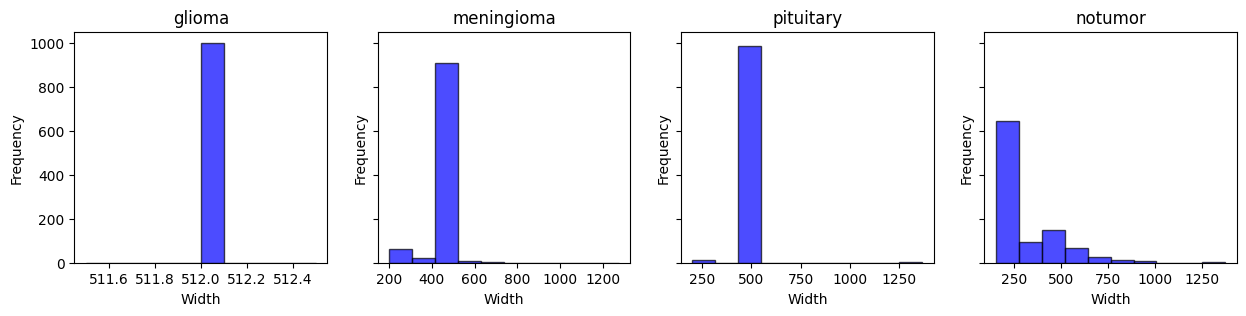

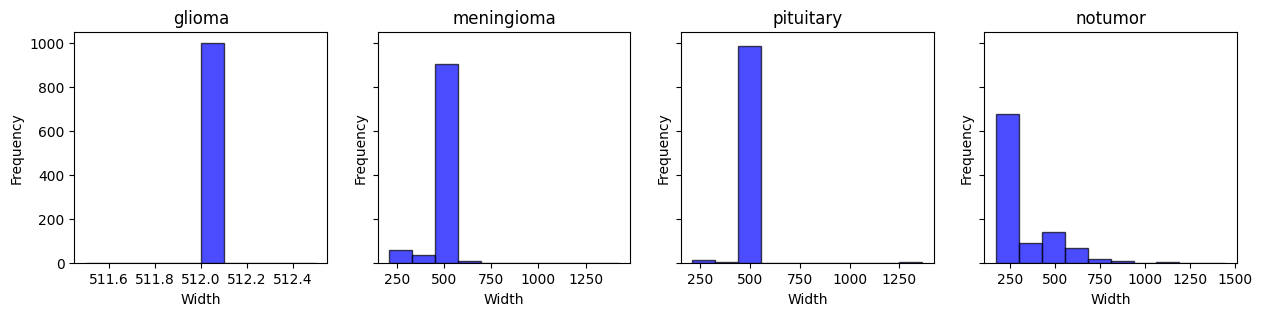

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

plot_histogram(w1, title=l1, xlabel='Width', ax=axs[0])
plot_histogram(w2, title=l2, xlabel='Width', ax=axs[1])
plot_histogram(w3, title=l3, xlabel='Width', ax=axs[2])
plot_histogram(w4, title=l4, xlabel='Width', ax=axs[3])

fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

plot_histogram(h1, title=l1, xlabel='Width', ax=axs[0])
plot_histogram(h2, title=l2, xlabel='Width', ax=axs[1])
plot_histogram(h3, title=l3, xlabel='Width', ax=axs[2])
plot_histogram(h4, title=l4, xlabel='Width', ax=axs[3])

It's clear that images vary in dimensions, which means they require preprocessing to ensure uniformity.

# Data Preprocessing and Augmentation

---

This section focuses on preparing the data for training through preprocessing and augmentation techniques. Using TensorFlow's ImageDataGenerator, parameters for both data rescaling and augmentation are specified. This includes techniques such as rotation, shifting, shearing, zooming, and flipping, which introduce variations in the training images, thereby enhancing the model's robustness. It's worth noting that the validation and test images are rescaled without undergoing augmentation to maintain their integrity.

These configured generators are then employed to flow the training, validation, and test images in batches of 32, ensuring efficient processing for model training and evaluation. The resulting output provides a summary of the number of images found in each dataset along with their respective classes.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator for training images.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Add our data-augmentation parameters to ImageDataGenerator for validation and test images without augmenting the data.
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Flow training, validation and test images in batches of 32 using data generators.

print("Training dataset:")
train_generator = train_datagen.flow_from_directory(
    './new/train',                            # Generate batches of data by loading the images from the specified directory.
    target_size=(150, 150),                   # Resize the dimensions of the images.
    batch_size= 32,
    class_mode='categorical'                  # Encode labels as one-hot vectors for the multi-classification task.
)

print("\nValidation dataset:")
val_generator = val_datagen.flow_from_directory(
    './new/val',
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

print("\nTest dataset:")
test_generator = test_datagen.flow_from_directory(
    './new/test',
    target_size=(150, 150),
    batch_size= 32,
    class_mode='categorical'
)

Training dataset:
Found 4000 images belonging to 4 classes.

Validation dataset:
Found 1200 images belonging to 4 classes.

Test dataset:
Found 1284 images belonging to 4 classes.


# Multi-Layer CNN Architecture

---
This section presents a 5-layer convolutional neural network (CNN) architecture for image classification tasks. The model consists of four convolutional layers followed by max-pooling layers for feature extraction, culminating in a fixed layer with dropout regularization to prevent overfitting. The output layer utilizes softmax activation for multi-class classification. The model is compiled with the Adam optimizer and categorical cross-entropy loss function.

The training process involves setting up training parameters and employing callbacks for monitoring and improving model performance. These callbacks include early stopping to prevent overfitting, and model checkpointing to save the best-performing model. The model is trained using the training generator with a specified number of epochs, and its performance is evaluated on the validation dataset.

Finally, the trained model is evaluated on the test dataset to assess its generalization performance. The test accuracy of the base model is computed and displayed.

In [21]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create our base model with 4 covolution layers, 1 fixed layer and regularization using Dropout.
inputs = Input(shape=(150, 150, 3), name="Input")
x = Conv2D(filters=16, kernel_size=3, activation='relu', name="Convolution_layer_1")(inputs)
x = MaxPooling2D(pool_size=2, name="Pooling_layer_1")(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', name="Convolution_layer_2")(x)
x = MaxPooling2D(pool_size=2, name='Pooling_layer_2')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', name="Convolution_layer_3")(x)
x = MaxPooling2D(pool_size=2, name='Pooling_layer_3')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', name="Convolution_layer_4")(x)
x = MaxPooling2D(pool_size=2, name='Pooling_layer_4')(x)
x = Flatten()(x)
x = Dense(512, activation='relu', name="Fixed_layer_1")(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax', name="Output_layer")(x)

model_1 = Model(inputs=inputs, outputs=outputs, name="Base_model")

In [22]:
# Show the base model summary.
model_1.summary()

Model: "Base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolution_layer_1 (Conv2D)         │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pooling_layer_1 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolution_layer_2 (Conv2D)         │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pooling_layer_2 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolution_layer_3 (Conv2D)         │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pooling_layer_3 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolution_layer_4 (Conv2D)         │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pooling_layer_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fixed_layer_1 (Dense)                │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,668,708 (6.37 MB)

 Trainable params: 1,668,708 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Set the training parameters.
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
import math
from tensorflow.keras import callbacks

# Calculate steps_per_epoch by dividing total number of trainin images with the trainin batch size.
steps_per_epoch_train = math.ceil(train_generator.samples / train_generator.batch_size)

epochs = 30

callbacks = [
    # Interrupt training once validation set accuracy stops improving for 5 epochs.
    callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3),

    # Saves the best seen mdoel
    callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True)]

In [25]:
# Train the base model.
history_1 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch_train, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callbacks)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.4029 - loss: 1.2219 - val_accuracy: 0.5717 - val_loss: 1.0451
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5717 - val_loss: 1.0451
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.6117 - loss: 0.8914 - val_accuracy: 0.3967 - val_loss: 1.7008
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3967 - val_loss: 1.7008
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 323ms/step - accuracy: 0.6781 - loss: 0.7760 - val_accuracy: 0.5875 - val_loss: 1.0664
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5875 - val_loss: 1.0664
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - accuracy: 0.6947 - loss: 0.7378 - val_accuracy: 0.4783 - val_loss: 1.3095
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4783 - val_loss: 1.3095
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.7

In [26]:
# Evaluate the model on the test dataset
test_loss, test_acc = model_1.evaluate(test_generator)
print(f"Test accuracy of the base model: {test_acc:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7771 - loss: 0.5768
Test accuracy of the base model: 0.766


# Transfer Learning

---
We are using Transfer Learning with the InceptionV3 model. First, we will employ feature extraction, where we use the pre-trained InceptionV3 model to extract features from our dataset without modifying the model's weights. We will see how well these extracted features perform on our task. Next, we will apply fine-tuning, where we unfreeze some of the top layers of the pre-trained model and retrain them on our dataset to adapt the features more closely to our specific task.


In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model without the top layers
conv_base_1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

conv_base_1.summary()

**Feature extraction with InceptionV3**

In [102]:
# Freeze the weights of the base model
for layer in conv_base_1.layers:
  layer.trainable = False

inputs = Input(shape=(150, 150, 3), name="Input")
x= conv_base_1(inputs)

# Add a new convolutional layer
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Additional_Conv_Layer_1')(x)

x = Flatten()(x)
x = Dense(512, activation='relu', name="Fixed_layer_1")(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax', name="Output_layer")(x)

model_2 = Model(inputs=inputs, outputs=outputs, name='Model_with_Feature_Extraction')

In [96]:
# Show the model summary
model_2.summary()

Model: "Model_with_Feature_Extraction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Additional_Conv_Layer (Conv2D)       │ (None, 3, 3, 64)            │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fixed_layer_1 (Dense)                │ (None, 512)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,279,972 (88.81 MB)

 Trainable params: 1,477,188 (5.64 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [103]:
# Set the training parameters.
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
# Train the model.
history_2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch_train, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callbacks)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - accuracy: 0.5575 - loss: 1.8083 - val_accuracy: 0.7492 - val_loss: 0.6410
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7492 - val_loss: 0.6410
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.7715 - loss: 0.5787 - val_accuracy: 0.7550 - val_loss: 0.6646
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7550 - val_loss: 0.6646
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 229ms/step - accuracy: 0.8034 - loss: 0.5353 - val_accuracy: 0.7467 - val_loss: 0.7227
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7467 - val_loss: 0.7227


In [105]:
# Evaluate the model on the test dataset
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test accuracy of the model with Feature Extraction: {test_acc:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.7988 - loss: 0.5558
Test accuracy of the model with Feature Extraction: 0.815


**Fine-tuning with InceptionV3**

In [106]:
# Load the InceptionV3 model without the top layers
conv_base_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

conv_base_2.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 74, 74, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 74, 74, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 72, 72, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 72, 72, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 35, 35, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 35, 35, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 35, 35, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [137]:
conv_base_2.trainable = True
for layer in conv_base_2.layers:
  layer.trainable = False

# Choose 'mixed7' as the last layer of our base model
last_layer = conv_base_2.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

# Add a new convolutional layer
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Additional_Conv_Layer_2')(last_output)

#inputs = Input(shape=(150, 150, 3), name="Input")
x = Flatten()(x)
x = Dense(512, activation='relu', name="Fixed_layer_1")(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax', name="Output_layer")(x)

model_3 = Model(inputs=conv_base_2.input, outputs=outputs, name="Model_with_Fine_Tuning")

In [138]:
# Show the model summary
model_3.summary()

Model: "Model_with_Fine_Tuning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 74, 74, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 74, 74, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 72, 72, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 72, 72, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 35, 35, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 35, 35, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 35, 35, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 11,025,892 (42.06 MB)

 Trainable params: 2,050,628 (7.82 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [139]:
# Set the training parameters.
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
# Train the model.
history_3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch_train, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callbacks)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - accuracy: 0.6133 - loss: 0.9006 - val_accuracy: 0.7975 - val_loss: 0.5767
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7975 - val_loss: 0.5767
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.8659 - loss: 0.3907 - val_accuracy: 0.8400 - val_loss: 0.4197


In [141]:
# Evaluate the model on the test dataset
test_loss, test_acc = model_3.evaluate(test_generator)
print(f"Test accuracy of the model with Fine-Tuning: {test_acc:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9001 - loss: 0.2758
Test accuracy of the model with Fine-Tuning: 0.900


# Model's Comparison

---

To compare the performance of multiple models, their training histories are extracted, including accuracy and loss metrics for both training and validation sets. For each model, the accuracy and loss values across epochs are stored. This information allows for a detailed comparison of how the models perform over the course of training.

In [142]:
acc1 = history_1.history['accuracy']
val_acc1 = history_1.history['val_accuracy']
loss1 = history_1.history['loss']
val_loss1 = history_1.history['val_loss']

epochs1 = range(len(acc1))

acc2 = history_2.history['accuracy']
val_acc2 = history_2.history['val_accuracy']
loss2 = history_2.history['loss']
val_loss2 = history_2.history['val_loss']

epochs2 = range(len(acc2))

acc3 = history_3.history['accuracy']
val_acc3 = history_3.history['val_accuracy']
loss3 = history_3.history['loss']
val_loss3 = history_3.history['val_loss']

epochs3 = range(len(acc3))

In [143]:
def make_plots(epochs, acc, col, label, ax, title):
    ax.plot(epochs, acc, col, label=label)
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(0, 10)

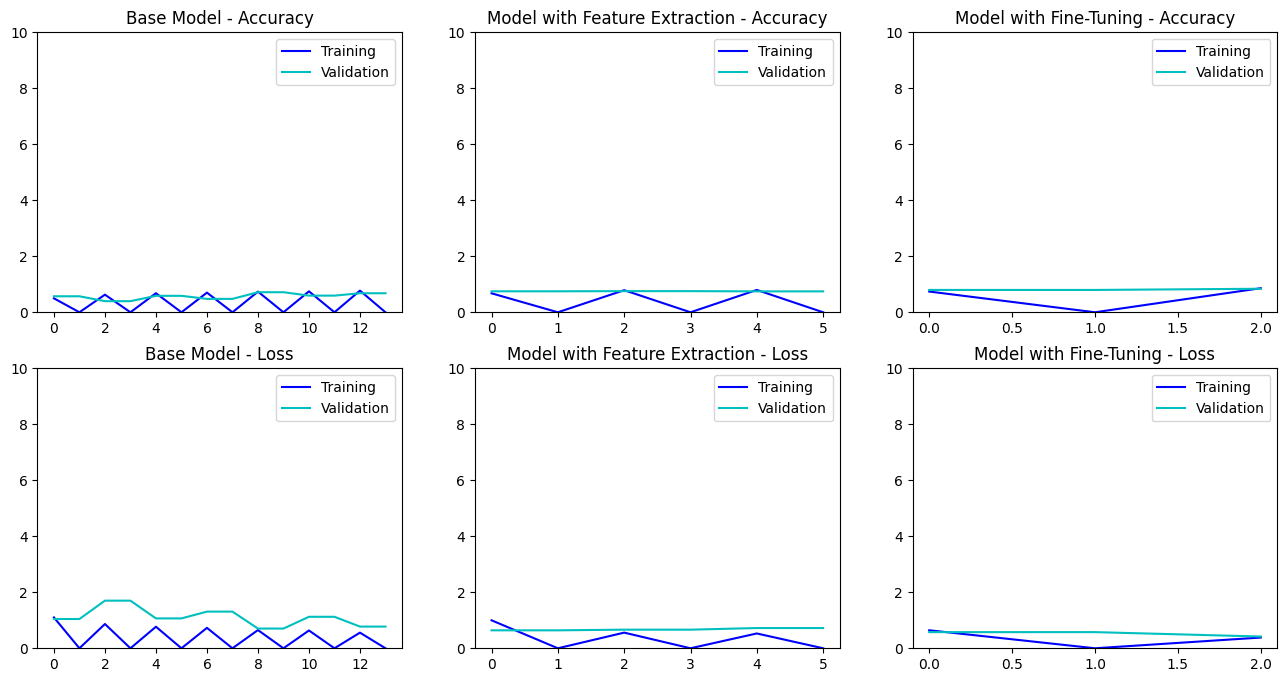

In [144]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,8))

make_plots(epochs1, acc1, 'b', 'Training', ax1, "Base Model - Accuracy")
make_plots(epochs1, val_acc1, 'c', 'Validation', ax1, "Base Model - Accuracy")

make_plots(epochs2, acc2, 'b', 'Training', ax2, "Model with Feature Extraction - Accuracy")
make_plots(epochs2, val_acc2, 'c', 'Validation', ax2, "Model with Feature Extraction - Accuracy")

make_plots(epochs3, acc3, 'b', 'Training', ax3, "Model with Fine-Tuning - Accuracy")
make_plots(epochs3, val_acc3, 'c', 'Validation', ax3, "Model with Fine-Tuning - Accuracy")


make_plots(epochs1, loss1, 'b', 'Training', ax4, "Base Model - Loss")
make_plots(epochs1, val_loss1, 'c', 'Validation', ax4, "Base Model - Loss")

make_plots(epochs2, loss2, 'b', 'Training', ax5, "Model with Feature Extraction - Loss")
make_plots(epochs2, val_loss2, 'c', 'Validation', ax5, "Model with Feature Extraction - Loss")

make_plots(epochs3, loss3, 'b', 'Training', ax6, "Model with Fine-Tuning - Loss")
make_plots(epochs3, val_loss3, 'c', 'Validation', ax6, "Model with Fine-Tuning - Loss")

**Observation:** Model with Fine_tuning seems to perform better than the other models.

# Class Activation Map

In [118]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
import keras

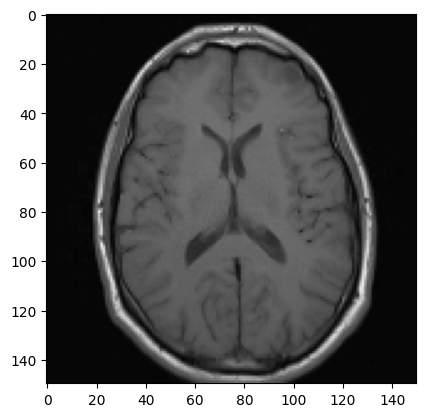

In [119]:
img_path = '/content/new/train/notumor/Tr-noTr_0002.jpg'
img = load_img(img_path, target_size=(150,150))
plt.imshow(img)

In [120]:
img_array = preprocess_image(img)
predictions = model_1.predict(img_array)
predicted_class_id = np.argmax(predictions[0])
predicted_class_id

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2

In [145]:
# For model_1
last_conv_layer_name_model_1 = 'Convolution_layer_4'
last_conv_layer_name_model_2 = 'Additional_Conv_Layer_1'
last_conv_layer_name_model_3 = 'Additional_Conv_Layer_2'

In [146]:
# Generate class activation heatmaps
heatmap_1 = make_gradcam_heatmap(img_array, model_1, last_conv_layer_name_model_1)
heatmap_2 = make_gradcam_heatmap(img_array, model_2, last_conv_layer_name_model_2)
heatmap_3 = make_gradcam_heatmap(img_array, model_3, last_conv_layer_name_model_3)

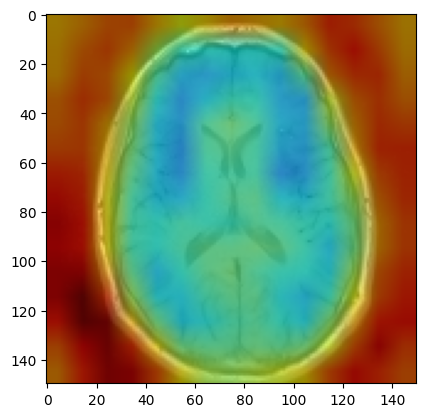

In [147]:
save_and_display_gradcam(img_path, heatmap_1)

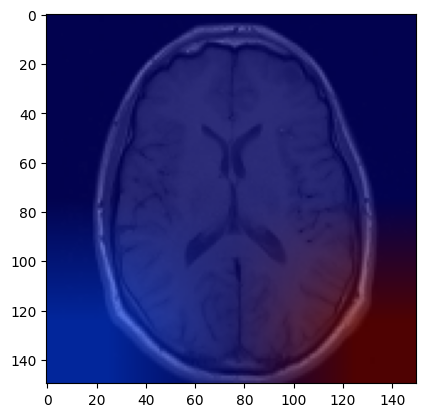

In [148]:
save_and_display_gradcam(img_path, heatmap_2)

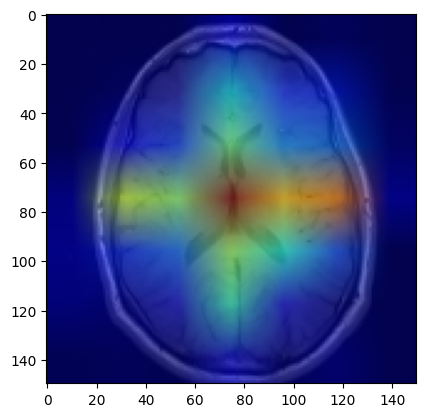

In [149]:
save_and_display_gradcam(img_path, heatmap_3)

**Future Improvements:** Train the best model with more data, varying learning rates, and dropout rates for a sufficient number of epochs.